In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tables_io
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown
from rail.core.util_stages import ColumnMapper, TableConverter
#from rail.estimation.algos.tpz_lite import TPZliteInformer
import rail
from rail.core.utils import RAILDIR
import qp
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle
from rail.core.stage import RailStage
#from rail.estimation.algos.tpz_lite import TPZliteEstimator
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer
from rail.estimation.algos.var_inf import VarInfStackSummarizer
from rail.evaluation.metrics.cdeloss import *
from qp.metrics.pit import PIT

In [2]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [41]:

catalog = 'GAMA' # Choose GAMA or VIPERS
training_csv_file = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/training.control_{catalog}_cut', sep=' ')
testing_csv_file = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/validation.control_{catalog}_cut', sep=' ')



In [42]:
vipers_train = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/training.control_VIPERS_cut', sep=' ')
vipers_test = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/validation.control_VIPERS_cut', sep=' ')
gama_train = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/training.control_GAMA_cut', sep=' ')
gama_test = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/validation.control_GAMA_cut', sep=' ')

gama = pd.concat([gama_train,gama_test])
gama = gama.reset_index(drop=True)
vipers = pd.concat([vipers_train,vipers_test])
vipers = vipers.reset_index(drop=True)

# Reading data

### Choosing the train fraction

In [43]:
# Function to select random sample for training and validation given a fraction of training (nothing to change here !!!)


def fraction (trainfrac, training_csv_file, testing_csv_file):
    if trainfrac==0.5:
        return training_csv_file, testing_csv_file
    else:
        df = pd.concat([training_csv_file, testing_csv_file])
        df = df.reset_index(drop=True)

        training_csv = df.sample(frac=trainfrac,random_state=1)
        testing_csv = df.drop(training_csv.index)
    
        return training_csv, testing_csv

In [44]:
trainfrac = 0.5 #Choose the fraction of data used to train

training_csv, testing_csv = fraction(trainfrac,training_csv_file,testing_csv_file) 


In [45]:
training_csv

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
0,0.399078,20.199528,19.273966,18.913313,18.662806,18.603645,0.011275,0.006362,0.007132,0.011448,0.043476,0.925562,0.360653,0.250507,0.059160,0.004913,-0.000769,-0.004316,-0.032027
1,0.179519,20.074409,19.185791,18.737385,18.449234,18.392519,0.008019,0.004664,0.004696,0.007159,0.023345,0.888618,0.448406,0.288151,0.056715,0.003355,-0.000032,-0.002462,-0.016186
2,0.149696,18.382769,17.327181,16.948246,16.654417,16.575659,0.003140,0.001649,0.001770,0.002982,0.006032,1.055588,0.378935,0.293829,0.078758,0.001490,-0.000121,-0.001211,-0.003050
3,0.102849,18.814003,18.100933,17.768396,17.556038,17.480537,0.002654,0.001828,0.002177,0.003341,0.011106,0.713070,0.332537,0.212358,0.075500,0.000826,-0.000349,-0.001165,-0.007765
4,0.287972,20.095467,19.322184,18.984856,18.786715,18.720091,0.008737,0.005486,0.006847,0.010649,0.021997,0.773283,0.337328,0.198141,0.066624,0.003251,-0.001361,-0.003803,-0.011348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8544,0.181951,19.505201,18.630213,18.233862,18.008234,17.935984,0.004256,0.002469,0.002799,0.004410,0.011365,0.874989,0.396351,0.225628,0.072250,0.001787,-0.000330,-0.001611,-0.006955
8545,0.135812,19.421814,19.157019,19.003096,18.970249,19.111612,0.006925,0.006546,0.010053,0.017464,0.065253,0.264795,0.153923,0.032846,-0.141363,0.000379,-0.003507,-0.007411,-0.047789
8546,0.042392,18.404402,18.096552,18.005510,17.914120,17.875111,0.003485,0.003340,0.005246,0.009009,0.030191,0.307850,0.091042,0.091391,0.039009,0.000145,-0.001907,-0.003763,-0.021182
8547,0.142024,20.005236,19.220055,18.929390,18.705160,18.670866,0.005421,0.003626,0.004933,0.006891,0.022701,0.785181,0.290665,0.224230,0.034294,0.001795,-0.001307,-0.001958,-0.015810


In [46]:
testing_csv

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
0,0.121010,19.086981,18.289202,17.947588,17.716686,17.560091,0.003340,0.002128,0.002814,0.003936,0.010994,0.797779,0.341614,0.230902,0.156595,0.001212,-0.000686,-0.001122,-0.007057
1,0.148008,18.570215,17.659454,17.285837,17.022526,16.903294,0.003177,0.001770,0.002338,0.003574,0.011399,0.910761,0.373617,0.263311,0.119232,0.001407,-0.000568,-0.001236,-0.007825
2,0.258799,19.289951,18.376232,17.957041,17.725811,17.651560,0.004813,0.002824,0.003506,0.004960,0.016376,0.913719,0.419191,0.231230,0.074251,0.001989,-0.000683,-0.001454,-0.011416
3,0.179280,19.570534,18.930767,18.647455,18.484583,18.449978,0.005208,0.003961,0.005374,0.007541,0.024807,0.639767,0.283312,0.162872,0.034605,0.001247,-0.001413,-0.002167,-0.017266
4,0.461377,20.375780,19.127642,18.698647,18.375963,18.233425,0.013104,0.005657,0.006257,0.008471,0.025427,1.248138,0.428995,0.322683,0.142538,0.007447,-0.000600,-0.002214,-0.016956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,0.075872,17.897518,17.358606,17.092911,16.907888,16.802795,0.001989,0.001675,0.002275,0.003286,0.008722,0.538912,0.265696,0.185022,0.105093,0.000314,-0.000600,-0.001011,-0.005436
8546,0.232149,19.659870,18.734676,18.314220,18.088778,18.026094,0.004534,0.002566,0.002865,0.004120,0.011740,0.925194,0.420456,0.225443,0.062683,0.001968,-0.000299,-0.001255,-0.007620
8547,0.133769,19.021547,18.504250,18.199669,18.072639,18.019913,0.003292,0.002887,0.003169,0.005093,0.014261,0.517298,0.304581,0.127029,0.052727,0.000405,-0.000282,-0.001923,-0.009168
8548,0.236224,20.012468,19.113558,18.760971,18.567804,18.472000,0.007726,0.005006,0.005757,0.008998,0.024221,0.898911,0.352587,0.193167,0.095804,0.002720,-0.000751,-0.003241,-0.015223


### Changing columns according to RAIL

In [47]:
training_csv = training_csv.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)
testing_csv = testing_csv.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)
vipers = vipers.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)
gama = gama.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)

In [48]:
columns = [
    "redshift",
    "mag_g_lsst",
    "mag_r_lsst",
    "mag_i_lsst",
    "mag_z_lsst",
    "mag_y_lsst",
    "mag_err_g_lsst",
    "mag_err_r_lsst",
    "mag_err_i_lsst",
    "mag_err_z_lsst",
    "mag_err_y_lsst"
]

training_csv.columns = columns
testing_csv.columns = columns
gama.columns= columns
vipers.columns= columns

training_csv = training_csv.reset_index()
testing_csv = testing_csv.reset_index()
gama = gama.reset_index()
vipers = vipers.reset_index()

ValueError: Length mismatch: Expected axis has 29 elements, new values have 11 elements

In [11]:
testing_csv = testing_csv.drop('index',axis=1)
training_csv = training_csv.drop('index',axis=1)
vipers = vipers.drop('index',axis=1)
gama = gama.drop('index',axis=1)

In [12]:
training_csv

,redshift,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,0.399078,20.199528,19.273966,18.913313,18.662806,18.603645,0.011275,0.006362,0.007132,0.011448,0.043476
1,0.179519,20.074409,19.185791,18.737385,18.449234,18.392519,0.008019,0.004664,0.004696,0.007159,0.023345
2,0.149696,18.382769,17.327181,16.948246,16.654417,16.575659,0.003140,0.001649,0.001770,0.002982,0.006032
3,0.102849,18.814003,18.100933,17.768396,17.556038,17.480537,0.002654,0.001828,0.002177,0.003341,0.011106
4,0.287972,20.095467,19.322184,18.984856,18.786715,18.720091,0.008737,0.005486,0.006847,0.010649,0.021997
...,...,...,...,...,...,...,...,...,...,...,...
8544,0.181951,19.505201,18.630213,18.233862,18.008234,17.935984,0.004256,0.002469,0.002799,0.004410,0.011365
8545,0.135812,19.421814,19.157019,19.003096,18.970249,19.111612,0.006925,0.006546,0.010053,0.017464,0.065253
8546,0.042392,18.404402,18.096552,18.005510,17.914120,17.875111,0.003485,0.003340,0.005246,0.009009,0.030191
8547,0.142024,20.005236,19.220055,18.929390,18.705160,18.670866,0.005421,0.003626,0.004933,0.006891,0.022701


In [13]:
testing_csv

,redshift,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,0.121010,19.086981,18.289202,17.947588,17.716686,17.560091,0.003340,0.002128,0.002814,0.003936,0.010994
1,0.148008,18.570215,17.659454,17.285837,17.022526,16.903294,0.003177,0.001770,0.002338,0.003574,0.011399
2,0.258799,19.289951,18.376232,17.957041,17.725811,17.651560,0.004813,0.002824,0.003506,0.004960,0.016376
3,0.179280,19.570534,18.930767,18.647455,18.484583,18.449978,0.005208,0.003961,0.005374,0.007541,0.024807
4,0.461377,20.375780,19.127642,18.698647,18.375963,18.233425,0.013104,0.005657,0.006257,0.008471,0.025427
...,...,...,...,...,...,...,...,...,...,...,...
8545,0.075872,17.897518,17.358606,17.092911,16.907888,16.802795,0.001989,0.001675,0.002275,0.003286,0.008722
8546,0.232149,19.659870,18.734676,18.314220,18.088778,18.026094,0.004534,0.002566,0.002865,0.004120,0.011740
8547,0.133769,19.021547,18.504250,18.199669,18.072639,18.019913,0.003292,0.002887,0.003169,0.005093,0.014261
8548,0.236224,20.012468,19.113558,18.760971,18.567804,18.472000,0.007726,0.005006,0.005757,0.008998,0.024221


In [14]:
data = pd.concat([training_csv,testing_csv],axis=0)

In [15]:
data

,redshift,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,0.399078,20.199528,19.273966,18.913313,18.662806,18.603645,0.011275,0.006362,0.007132,0.011448,0.043476
1,0.179519,20.074409,19.185791,18.737385,18.449234,18.392519,0.008019,0.004664,0.004696,0.007159,0.023345
2,0.149696,18.382769,17.327181,16.948246,16.654417,16.575659,0.003140,0.001649,0.001770,0.002982,0.006032
3,0.102849,18.814003,18.100933,17.768396,17.556038,17.480537,0.002654,0.001828,0.002177,0.003341,0.011106
4,0.287972,20.095467,19.322184,18.984856,18.786715,18.720091,0.008737,0.005486,0.006847,0.010649,0.021997
...,...,...,...,...,...,...,...,...,...,...,...
8545,0.075872,17.897518,17.358606,17.092911,16.907888,16.802795,0.001989,0.001675,0.002275,0.003286,0.008722
8546,0.232149,19.659870,18.734676,18.314220,18.088778,18.026094,0.004534,0.002566,0.002865,0.004120,0.011740
8547,0.133769,19.021547,18.504250,18.199669,18.072639,18.019913,0.003292,0.002887,0.003169,0.005093,0.014261
8548,0.236224,20.012468,19.113558,18.760971,18.567804,18.472000,0.007726,0.005006,0.005757,0.008998,0.024221


## Functions

In [14]:
def plot_redshift(catalog):
    plt.figure(figsize=(8,8))
    plt.hist(catalog['redshift'],bins=201,density=True,color='red')
    plt.xlabel('Redshift', fontsize=13)
    plt.ylabel('Normalized Counts', fontsize=13)
    plt.show()

In [15]:
def plot_errors(catalog):
    bands = ['g', 'r', 'i', 'z', 'y']
    j=1
    plt.figure(figsize=[9,13])
    for i, band in enumerate(bands):

        plt.subplot(3,2,j) 
        mag = np.array(catalog[f'mag_{band}_lsst'])
        err = np.array(catalog[f'mag_err_{band}_lsst'])
        sn = 1/(10**(0.4*err)-1)
        plt.hexbin(mag,sn , None, mincnt=1, cmap='inferno', gridsize=[400,200], bins='log')
        cbar = plt.colorbar()
        plt.ylabel("S/R ", fontsize=13)
        plt.xlabel("mag "+band, fontsize=13)
        plt.ylim(0,100)
        plt.xlim(15,30)
        plt.axhline(10, color= 'red')
        plt.grid(True)
        j+=1
        plt.tight_layout()

In [16]:
def mag_color(catalog):
    bands = ['u', 'g', 'r', 'i', 'z','y']
    mag_diff = {}
    plt.figure(figsize=(9,13))
    i=1
    for band,_band in zip(bands, bands[1::]):
        plt.subplot(3,2,i)
        i+=1
        mag_diff_v = catalog[f'mag_{band}_lsst']-catalog[f'mag_{_band}_lsst']
        mag_v = catalog[f'mag_{band}_lsst'] 
                   
        plt.hexbin(mag_v, mag_diff_v, None, mincnt=1, cmap='Reds', gridsize=[400,400], bins='log')

        plt.xlabel("mag "+band,fontsize=13)
        plt.ylabel(f"{band}-{_band}",fontsize=13)
        #plt.legend()
        plt.xlim(16,32)
        plt.ylim(-2,5)
        plt.grid(True)
        plt.tight_layout()
    plt.show()

In [18]:
def mag_color_comparation(catalog1,catalog2,name1,name2,path_to_save=''):
    bands = ['g', 'r', 'i', 'z','y']
    limits = [0,24.7,24.4,23.8,23.1,21.7]
    mag_diff = {}
    plt.figure(figsize=(9,13))
    i=1
    extra1 = catalog1[catalog1['mag_r_lsst']>19.8]
    catalog1 = catalog1[catalog1['mag_r_lsst']<19.8]
    extra2 = catalog2[catalog2['mag_i_lsst']>22.5]
    catalog2 = catalog2[catalog2['mag_i_lsst']<22.5]
    extra=pd.concat([extra1,extra2],axis=0)
    for band,_band in zip(bands, bands[1::]):
        plt.subplot(3,2,i)
        i+=1
        mag_diff_v1= catalog1[f'mag_{band}_lsst']-catalog1[f'mag_{_band}_lsst']
        mag_v1 = catalog1[f'mag_{band}_lsst'] 
        mag_diff_v2= catalog2[f'mag_{band}_lsst']-catalog2[f'mag_{_band}_lsst']
        mag_v2 = catalog2[f'mag_{band}_lsst']
        mag_diff= extra[f'mag_{band}_lsst']-extra[f'mag_{_band}_lsst']
        mag = extra[f'mag_{band}_lsst'] 
                   
        plt.scatter(mag_v1, mag_diff_v1, color='#4B0082',s=0.01)
        plt.scatter(mag_v2, mag_diff_v2, color='#00008B',s=0.01)
        plt.scatter(mag,mag_diff,color='orange',s=0.01)
        if band =='i':
            plt.axvline(22.5,color='#00008B')
        if band =='r':
            plt.axvline(19.8,color='#4B0082')
        # Adicionando pontos coloridos para cada label na legenda
        plt.scatter([], [], color='#4B0082', label=name1, marker='o')  # Ponto vermelho para a linha 1
        plt.scatter([], [], color='#00008B', label=name2, marker='o') 
        plt.scatter([], [], color='orange', label='Dados removidos', marker='o') 
        plt.legend(fontsize=13)
        plt.xlabel("mag "+band,fontsize=13)
        plt.ylabel(f"{band}-{_band}",fontsize=13)
        #plt.legend()
        plt.xlim(16,28)
        plt.ylim(-1,3.5)
        #plt.grid(True)
        plt.suptitle('Magnitude x Cor',fontsize=16)
        plt.tight_layout()
    if path_to_save == '':
        None
    else:
        plt.savefig(f'{path_to_save}mag_color.png')
    plt.show()

In [19]:
def mag_histogram(catalog, title='DP0.2'):
    
    bands = ['g', 'r', 'i', 'z','y']
    colors = ['blue', 'green', 'orange','red','purple','gray']
    plt.figure(figsize=(9,13))
    bins = np.linspace(9, 37, 57)
    j=1
    for i, (band, color) in enumerate(zip(bands,colors)):
        plt.subplot(3,2,j)
        plt.hist(catalog[f'mag_{band}_lsst'], histtype='stepfilled', bins=bins, label=f'{band} band', alpha = 0.5,
                 edgecolor = "black", color = color)
        #plt.xlim(16,27)
        plt.yscale('log')
        plt.xlabel('mag',fontsize=13)
        plt.ylabel('counts',fontsize=13)
        plt.legend(loc=2)
        plt.grid(True)
        j+=1
    plt.suptitle(title)
    plt.show()


In [20]:
def color_color_red(catalog,xlim=[-1,3],ylim=[-1,3]):
    bands = ['g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(color-next_color,past_color-color, C=catalog['redshift'], mincnt=1, cmap='RdYlBu', gridsize=[150,75])        
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar(label='redshift')
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
    plt.show()

In [21]:
def color_color(catalog):
    bands = ['g', 'r', 'i', 'z','y']
    i=1
    plt.figure(figsize=(12,12))
    for index in range(len(bands)-2):
        plt.subplot(3,2,i)
        i+=1
        color = catalog[f'mag_{bands[index+1]}_lsst']
        next_color = catalog[f'mag_{bands[index+2]}_lsst']
        past_color = catalog[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(color-next_color,past_color-color, None, mincnt=1, cmap='turbo', gridsize=[400,400], bins='log')
        plt.xlabel(f'{bands[index+1]}-{bands[index+2]}',fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index+1]}',fontsize=13)
        cbar = plt.colorbar()
        plt.xlim(-2,5)
        plt.ylim(-2,5)
    plt.show()

In [22]:
def color_color_comparation(catalog1, catalog2, name1, name2,path_to_save=''):
    bands = ['g', 'r', 'i', 'z', 'y']
    i = 1
    plt.figure(figsize=(12, 12))
    for index in range(len(bands) - 2):
        plt.subplot(3, 2, i)  # Primeira subplot
        color1 = catalog1[f'mag_{bands[index + 1]}_lsst']
        next_color1 = catalog1[f'mag_{bands[index + 2]}_lsst']
        past_color1 = catalog1[f'mag_{bands[index]}_lsst']
        color2 = catalog2[f'mag_{bands[index + 1]}_lsst']
        next_color2 = catalog2[f'mag_{bands[index + 2]}_lsst']
        past_color2 = catalog2[f'mag_{bands[index]}_lsst']
        
        plt.hexbin(color1 - next_color1, past_color1 - color1, None, mincnt=1, cmap='turbo', gridsize=[400, 400], bins='log')
        cbar = plt.colorbar(cmap='turbo')
        plt.xlabel(f'{bands[index + 1]}-{bands[index + 2]}', fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index + 1]}', fontsize=13)
        plt.scatter([],[],color='white',s=0,label=name1)
        plt.legend(fontsize=14,loc=2,handlelength=0)
        plt.xlim(-2, 2)
        plt.ylim(-1, 3)
        i += 1
        
        plt.subplot(3, 2, i)  # Segunda subplot
        plt.hexbin(color2 - next_color2, past_color2 - color2, None, mincnt=1, cmap='turbo', gridsize=[400, 400], bins='log')
        cbar = plt.colorbar(cmap='turbo')
        plt.xlabel(f'{bands[index + 1]}-{bands[index + 2]}', fontsize=13)
        plt.ylabel(f'{bands[index]}-{bands[index + 1]}', fontsize=13)
        plt.scatter([],[],color='white',s=0,label=name2)
        plt.legend(fontsize=14,loc=2,handlelength=0)   
        plt.xlim(-2, 2)
        plt.ylim(-1, 3)
        i += 1
    plt.suptitle('Cor x Cor',fontsize=17)
    plt.tight_layout()  # Ajuste automático dos subplots
    
    if path_to_save == '':
        None
    else:
        plt.savefig(f'{path_to_save}color_color.png')
    plt.show()

## Plots

In [25]:
bands = ['g','r','i','z','y']
limits = []
limits_train = []
limits_test = []
print(f'Before cuts: {len(data)}')
for band in bands:
    #training_csv = training_csv[training_csv['mag_g_lsst']<24.7]
    #training_csv = training_csv[training_csv['mag_y_lsst']<21.7]
    training_csv = training_csv[training_csv['mag_i_lsst']<22.5]
    testing_csv = testing_csv[testing_csv['mag_i_lsst']<22.5]
    data=data[data['mag_i_lsst']<22.5]
    #testing_csv = testing_csv[testing_csv['mag_g_lsst']<24.7]
    #testing_csv = testing_csv[testing_csv['mag_y_lsst']<21.7]
    #data = data[data['mag_g_lsst']<24.7]
    #data = data[data['mag_y_lsst']<21.7]
    
    limits_train.append(max(training_csv[f'mag_{band}_lsst']))
    limits_test.append(max(testing_csv[f'mag_{band}_lsst']))
    limits.append(max(data[f'mag_{band}_lsst']))
print(f'After cuts: {len(data)}')

Before cuts: 17099
After cuts: 17099


In [26]:
limits = np.round(limits,4)
limits_train = np.round(limits_train,4)
limits_test = np.round(limits_test,4)
print(limits)
print(limits_train)
print(limits_test)

[20.4    19.5499 19.5744 19.9252 20.2124]
[20.3999 19.5498 19.5496 19.9252 20.2124]
[20.4    19.5499 19.5744 19.4906 19.7951]


In [62]:
plot_redshift(catal)

KeyError: 'redshift'

<Figure size 800x800 with 0 Axes>

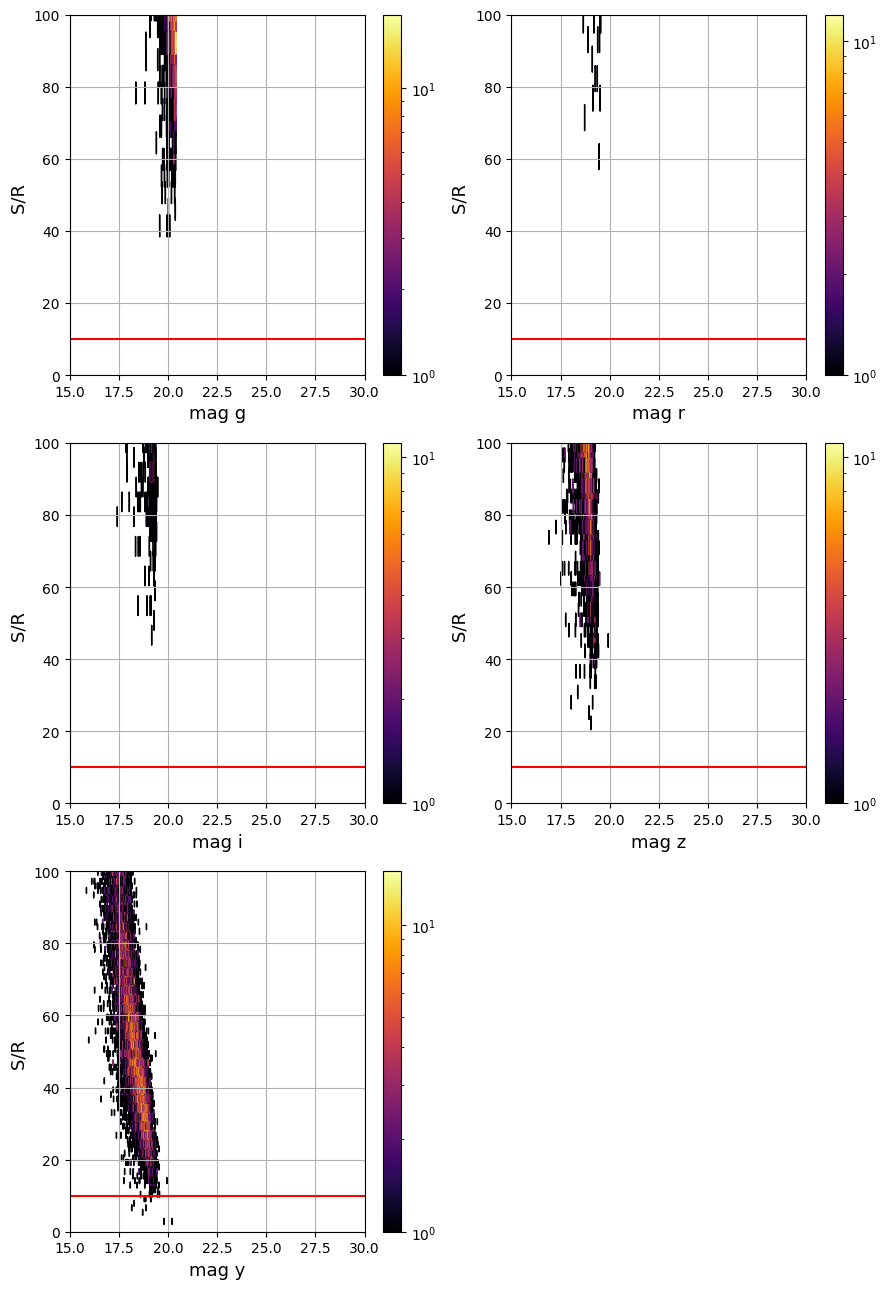

In [28]:
plot_errors(data)

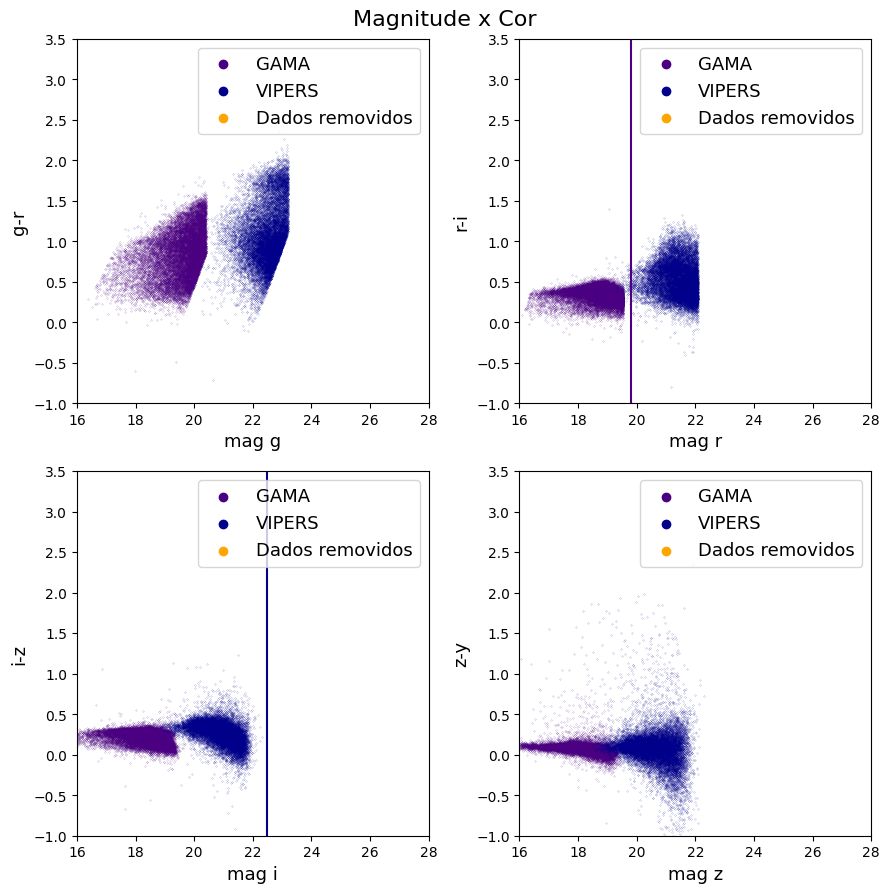

In [29]:
mag_color_comparation(gama,vipers,'GAMA','VIPERS')#,path_to_save='/home/iago.dias/')

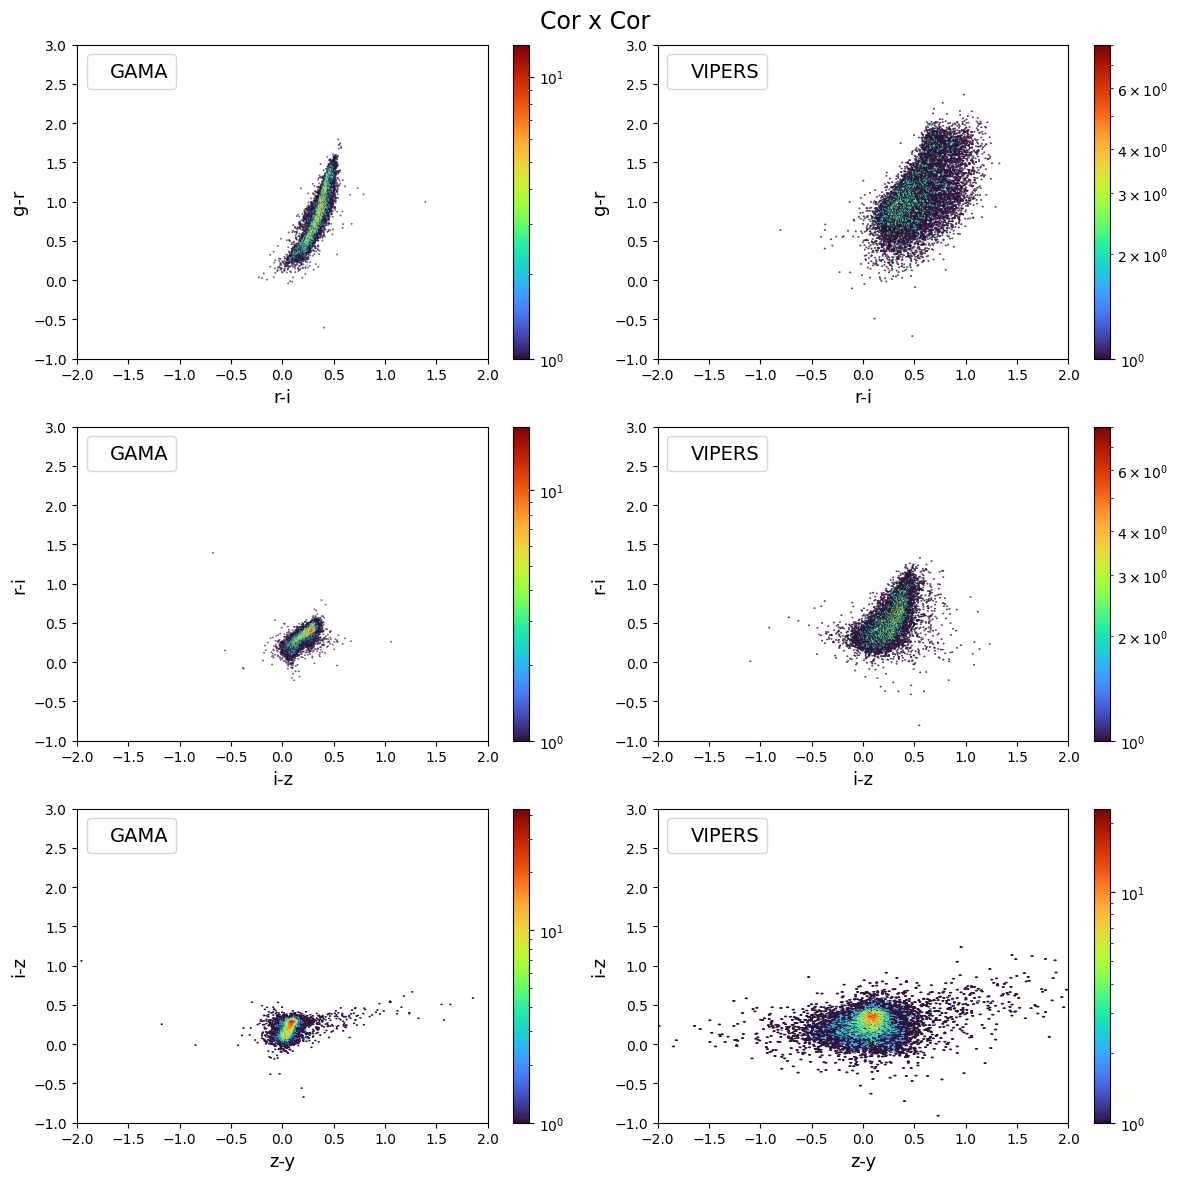

In [30]:
color_color_comparation(gama,vipers,'GAMA','VIPERS')#,path_to_save='/home/iago.dias/')

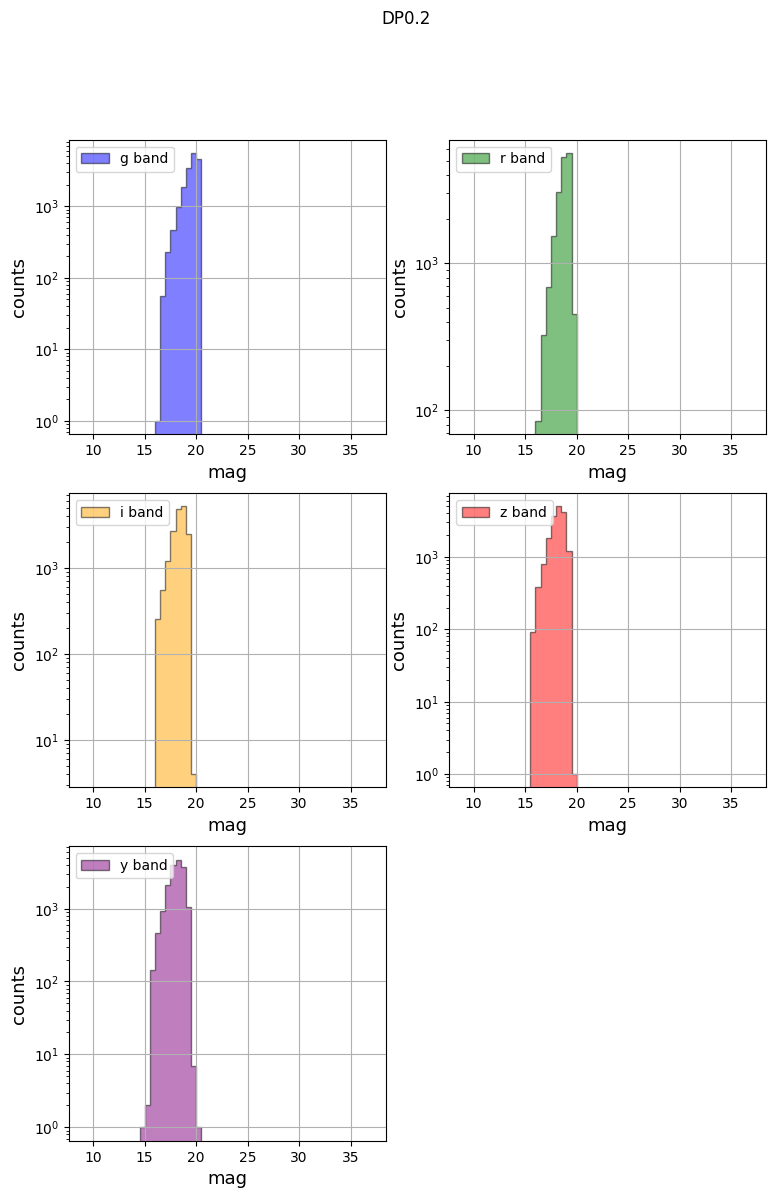

In [31]:
mag_histogram(data)

In [52]:
color_color(data)

NameError: name 'color_color' is not defined

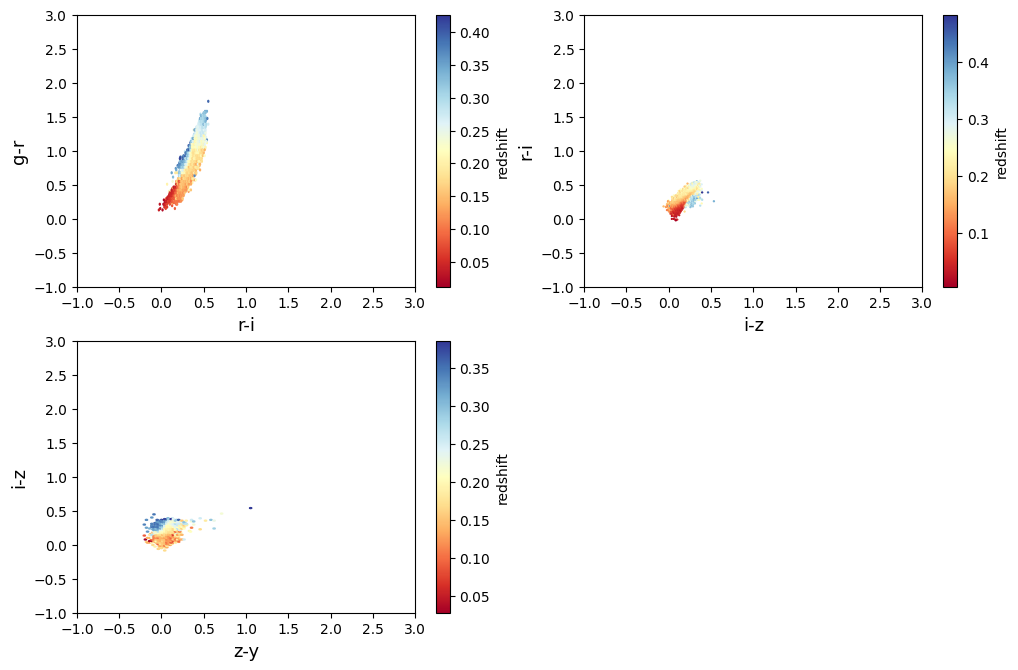

In [33]:
color_color_red(data)

## Training and testing

In [34]:
dic_train = training_csv.to_dict(orient='list')
dic_test = testing_csv.to_dict(orient='list')


for col, values in dic_train.items():
    dic_train[col] = np.array(values)
training_sample = {'photometry':dic_train}
for col, values in dic_test.items():
    dic_test[col] = np.array(values)
training_sample = {'photometry':dic_train}
testing_sample = {'photometry':dic_test}

In [35]:
training_sample = DS.add_data(data=training_sample, handle_class=TableHandle, key='photometry')
testing_sample = DS.add_data(data=testing_sample, handle_class=TableHandle, key='photometry')

In [36]:
training_sample.path = f'/home/iago.dias/IC_Photo-z/Iago/samples/training_control_{catalog}_cut.hdf5'
testing_sample.path = f'/home/iago.dias/IC_Photo-z/Iago/samples/validation_control_{catalog}_cut.hdf5'

In [37]:
print(len(training_sample.data['photometry']['redshift']))
print(len(testing_sample.data['photometry']['redshift']))

8549
8550


In [38]:
training_sample.write()
testing_sample.write()

'/home/iago.dias/IC_Photo-z/Iago/samples/validation_control_GAMA_cut.hdf5'

In [39]:
bands = ["g", "r", "i", "z", "y"]
new_err_dict = {}
attribute_list = []
for band in bands:
    attribute_list.append(f"mag_{band}_lsst")
    new_err_dict[f"mag_{band}_lsst"] = f"mag_err_{band}_lsst"
# redshift is also an attribute used in the training, but it does not have an associated
# error its entry in the err_dict should be set to "None"
new_err_dict["redshift"] = None

print(new_err_dict)

{'mag_g_lsst': 'mag_err_g_lsst', 'mag_r_lsst': 'mag_err_r_lsst', 'mag_i_lsst': 'mag_err_i_lsst', 'mag_z_lsst': 'mag_err_z_lsst', 'mag_y_lsst': 'mag_err_y_lsst', 'redshift': None}


In [40]:
tpz_dict = dict(zmin=min(data['redshift']), 
                zmax=max(data['redshift']), 
                nzbins=301, 
                hdf5_groupname='photometry',
                use_atts=attribute_list,
                err_dict=new_err_dict,
                nrandom=3, 
                ntrees=6)

In [41]:
pz_train = TPZliteInformer.make_stage(name='inform_TPZ', model='demo_tpz.pkl', **tpz_dict)

In [42]:
%%time
pz_train.inform(training_sample)

creating 3 random realizations...
making a total of 18 trees for 3 random realizations * 6 bootstraps
making 1 of 18...
making 2 of 18...
making 3 of 18...
making 4 of 18...
making 5 of 18...
making 6 of 18...
making 7 of 18...
making 8 of 18...
making 9 of 18...
making 10 of 18...
making 11 of 18...
making 12 of 18...
making 13 of 18...
making 14 of 18...
making 15 of 18...
making 16 of 18...
making 17 of 18...
making 18 of 18...
Inserting handle into data store.  model_inform_TPZ: inprogress_demo_tpz.pkl, inform_TPZ
CPU times: user 14min 15s, sys: 634 ms, total: 14min 16s
Wall time: 14min 27s


In [43]:
test_dict = dict(hdf5_groupname='photometry')
test_runner = TPZliteEstimator.make_stage(name="test_tpz", output="TPZ_demo_output.hdf5",
                                          model=pz_train.get_handle('model'), **test_dict)

In [44]:
%%time
output = test_runner.estimate(testing_sample)

Process 0 running estimator on chunk 0 - 8550
loading 18 total trees from model


/home/iago.dias/rail_tpz/src/rail/estimation/algos/mlz_utils/utils_mlz.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  ef = ((e68 - e681) / (area - area1)) * (0.68 - area1) + e681


Inserting handle into data store.  output_test_tpz: inprogress_TPZ_demo_output.hdf5, test_tpz
CPU times: user 14.6 s, sys: 231 ms, total: 14.8 s
Wall time: 15 s


In [45]:
output().write_to(f'/home/iago.dias/IC_Photo-z/Iago/results/results_TPz_control_{catalog}_cut.hdf5')


# Results

## Functions

In [3]:
def old_metrics_table(photoz, ztrue, name="", show_dc1=True):
    rows = ["|Metric |", "|:---|", "|scatter |", "|bias |", "|outlier rate |"]
    sigma_iqr, bias, frac, sigma_mad = old_metrics(photoz, ztrue)
    rows[0] += f"{name} |"
    rows[1] += "---:|"
    rows[2] += f"{sigma_iqr:11.4f} |"
    rows[3] += f"{bias:11.5f} |"
    rows[4] += f"{frac:11.3f} |"
    if show_dc1:
        rows[0] += "DC1 paper"
        rows[1] += "---:"
        rows[2] += f"  0.0154"
        rows[3] += f" -0.00027"
        rows[4] += f"  0.020"
    table = ("\n").join(rows)
    return Markdown(table)


In [4]:
def old_metrics(photoz, ztrue):
    point = EvaluatePointStats(photoz, ztrue)
    sigma_iqr = point.CalculateSigmaIQR()
    bias = point.CalculateBias()
    frac = point.CalculateOutlierRate()
    sigma_mad = point.CalculateSigmaMAD()
    return sigma_iqr, bias, frac, sigma_mad

In [5]:
class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


In [6]:
def plot_old_valid_comparation(photoz1,photoz, ztrue,title,photoz1name='',photozname='' ,gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot1}$': photoz1,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.scatter(ztrue, photoz1, color='blue', s=0.1,alpha=0.4)
    plt.scatter(ztrue, photoz, color='red',s=0.1 ,alpha=0.4)
    
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'k--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3,color='black')
    sns.kdeplot(photoz, shade=True, label=photozname,bw_adjust=0.7,color='red')
    sns.kdeplot(photoz1, shade=True, label=photoz1name,bw_adjust=0.7,color='blue')
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)

In [7]:
def plot_old_valid(photoz, ztrue,title, gals=None, colors=None, code="",path_to_save=''):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'r--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3)
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$',bw_adjust=0.3)
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    if path_to_save !='':
        plt.savefig(path_to_save)

In [8]:
def plot_metrics_comparation(zspec,
                 zphot1,
                 zphot2,
                 maximum,
                 name1='',
                 name2='',
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers1 = []
    sigma68z1 = []
    sigmaz1=[]
    meanz1 = []
    outliers_21 = []
    fraction_outliers1 = []
    sigma68z2 = []
    sigmaz2=[]
    meanz2 = []
    outliers_22 = []
    fraction_outliers2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r1 = zphot1[(zphot1 >= bin_lower) & (zphot1 <= bin_upper)]
        values_s1 = zspec[(zphot1 >= bin_lower) & (zphot1 <= bin_upper)]
        values_r2 = zphot2[(zphot2 >= bin_lower) & (zphot2 <= bin_upper)]
        values_s2 = zspec[(zphot2 >= bin_lower) & (zphot2 <= bin_upper)]
        
        

        deltabias1 = (values_r1 - values_s1)
        deltabias2 = (values_r2 - values_s2)
        
        mean_bias1 = np.mean(deltabias1)  # Mean bias for each bin
        meanz1.append(mean_bias1)
        mean_bias2 = np.mean(deltabias2)  # Mean bias for each bin
        meanz2.append(mean_bias2)
        
    
        s1 = np.sort(np.abs(deltabias1/(1+values_s1)))
        s2 = np.sort(np.abs(deltabias2/(1+values_s2)))# Standard deviation (sigma) for each bin
        sigma681 = s1[int(len(s1)*0.68)]
        sigma68z1.append(sigma681)
        sigma682 = s2[int(len(s2)*0.68)]
        sigma68z2.append(sigma682)
        
        
        
        sigma1 = (np.sum((values_r1-values_s1-mean_bias1)**2)/len(values_r1))**0.5
        sigmaz1.append(sigma1)
        sigma2 = (np.sum((values_r2-values_s2-mean_bias2)**2)/len(values_r2))**0.5
        sigmaz2.append(sigma2)
    
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers1 = deltabias1[np.abs(deltabias1-mean_bias1) > 3 * sigma1]
        fraction_outlier1 = len(outliers1) / len(deltabias1)
        fraction_outliers1.append(fraction_outlier1)
        outliers2 = deltabias2[np.abs(deltabias2 - mean_bias2) > 3 * sigma2]
        fraction_outlier2 = len(outliers2) / len(deltabias2)
        fraction_outliers2.append(fraction_outlier2)

        
    
        #2 sigma
        outliers21 = deltabias1[np.abs(deltabias1-mean_bias1) > 2 * sigma1]
        fraction_outlier21 = len(outliers21) / len(deltabias1)
        outliers_21.append(fraction_outlier21)
        outliers22 = deltabias2[np.abs(deltabias2 - mean_bias2) > 2 * sigma2]
        fraction_outlier22 = len(outliers22) / len(deltabias2)
        outliers_22.append(fraction_outlier22)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz1, 'bo-',label=name1)
    axes[0].plot(points[:-1], meanz2, 'ro-',label=name2)
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.05,0.05)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)
    axes[0].legend(loc=1)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z1, 'bo-',label=name1)
    axes[1].plot(points[:-1], sigma68z2, 'ro-',label=name2)
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.1)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)
    axes[1].legend(loc=1)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_21,'o-',color='blue',label=name1)
    axes[2].plot(points[:-1],outliers_22,'o-',color='red',label=name2)
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[2].legend(loc=1)

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers1, 'bo-',label=name1)
    axes[3].plot(points[:-1], fraction_outliers2, 'ro-',label=name2)
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.04)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
    axes[3].legend(loc=1)
   
    
    plt.suptitle(title)
    plt.xlim(0,1.4)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


In [9]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 path_to_save='',
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].set_ylim(-0.01,0.01)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    #axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    axes[1].set_ylim(0, 0.01)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    axes[2].set_ylim(0,0.12)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{spec}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,0.02)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,1.4)
    plt.tight_layout()

    if path_to_save != '':
        plt.savefig(f'{path_to_save}')
    

    plt.show()


# Results

In [10]:
path='/home/iago/IC_Photo-z/Iago/results'

In [11]:
catalog='VIPERS'

In [12]:
result1 = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/results_TPz_control_{catalog}_cut.hdf5')

result2 = DS.read_file('pdfs_data', QPHandle, 
                          f'{path}/results_fzb_control_{catalog}_squarederror_cut.hdf5')


In [13]:
############### True redshift #############
#catal = pd.read_hdf(f'/home/iago.dias/IC_Photo-z/Iago/samples/validation_control_{catalog}_0.5_cuts.hdf5')
catal = DS.read_file('photometry', TableHandle, 
                          f'/home/iago/IC_Photo-z/Iago/samples/validation_control_{catalog}_cut.hdf5')()

ztrue =  catal['photometry']['redshift']

############### Max redshift ##############
z_max = max(ztrue)

############ X values for plot ############
zgrid = np.linspace(0, z_max, 301)

################## PDFS ##################
pdfs1 = result1().build_tables()['data']['yvals']
pdfs2 = result2().build_tables()['data']['yvals']

In [14]:
mean1 = result1().mean()
mean2 = result2().mean()
mode1 = result1().mode(zgrid)
mode2 = result2().mode(zgrid)


########## Median or mode of PDF ##########

zphot1  = np.array([valor for sublista in mode1 for valor in sublista])
zphot2  = np.array([valor for sublista in mode2 for valor in sublista])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_15927/1688115127.py:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/tmp/ipykernel_15927/1688115127.py:38: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3,color='black')
/home/iago/miniforge3/envs/rail_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_15927/1688115127.py:39: Fut

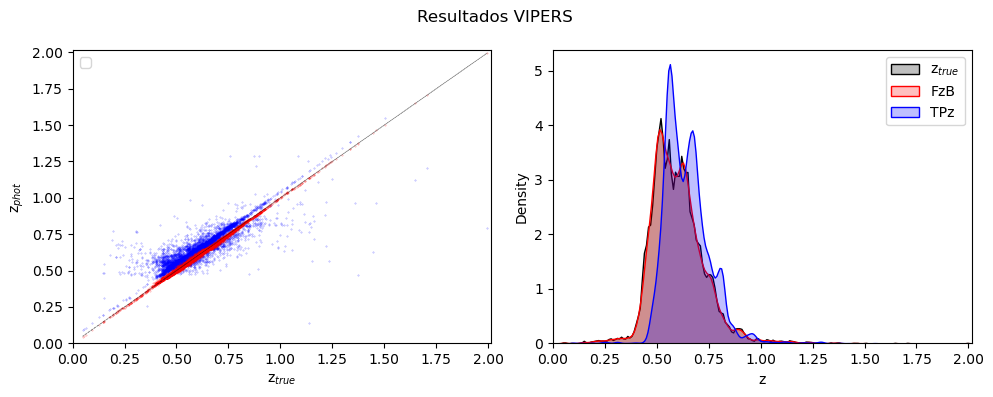

In [15]:

plot_old_valid_comparation(photoz1=zphot1,photoz=zphot2,title=f'Resultados {catalog}',photoz1name='TPz',photozname='FzB',ztrue=ztrue)#,path_to_save=f'/home/iago.dias/control_scatter_{catalog}_cut.png')


In [29]:
stacker_tpz = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=3.0, nzbins=41, nsamples=40, output=f"Naive_samples_tpz_test.hdf5", single_NZ=f"NaiveStack_NZ_tpz.hdf5")
stacker_fzb = NaiveStackSummarizer.make_stage(zmin=0.0, zmax=3.0, nzbins=41, nsamples=40, output=f"Naive_samples_fzb.hdf5", single_NZ=f"NaiveStack_NZ_fzb.hdf5")


In [30]:
naive_results_tpz = stacker_tpz.summarize(result1)
newens_tpz = naive_results_tpz.data
naive_results_fzb = stacker_fzb.summarize(result2)
newens_fzb = naive_results_fzb.data

Process 0 running estimator on chunk 0 - 7247
Inserting handle into data store.  output: inprogress_Naive_samples_tpz_test.hdf5, NaiveStackSummarizer
Inserting handle into data store.  single_NZ: inprogress_NaiveStack_NZ_tpz.hdf5, NaiveStackSummarizer
Process 0 running estimator on chunk 0 - 7247
Inserting handle into data store.  output: inprogress_Naive_samples_fzb.hdf5, NaiveStackSummarizer
Inserting handle into data store.  single_NZ: inprogress_NaiveStack_NZ_fzb.hdf5, NaiveStackSummarizer


Text(0.5, 0.98, 'N(z) Naive Stack_tpz')

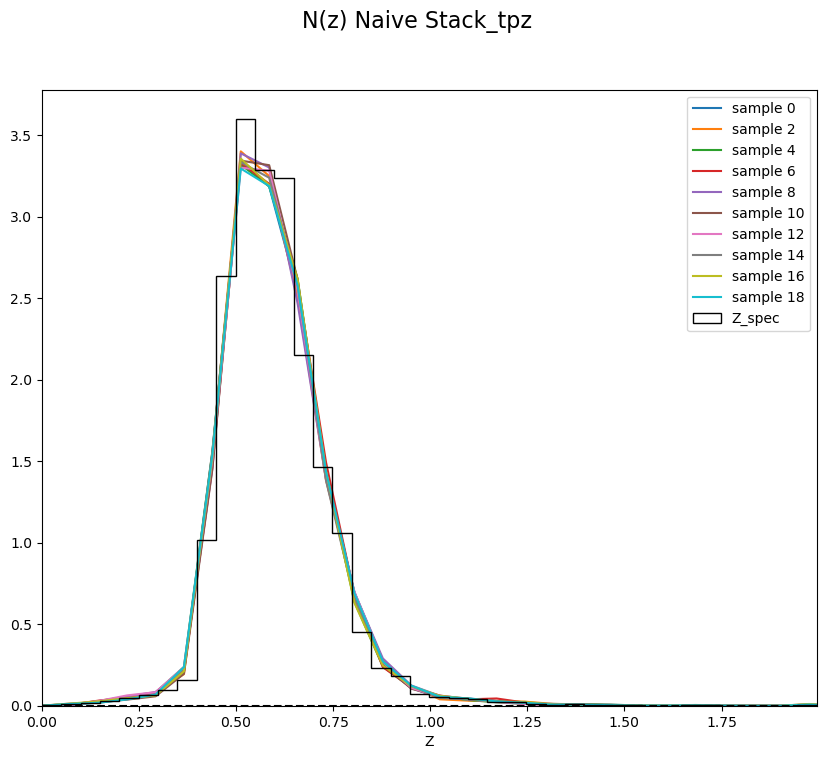

In [31]:
fig, axs = plt.subplots(figsize=(10,8))
for i in range(0, 20, 2):
    newens_tpz[i].plot_native(axes=axs, label=f"sample {i}")
axs.plot([0,3],[0,0],'k--')
axs.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,z_max,41),color='black',label='Z_spec')
axs.set_xlim(0,z_max)
axs.set_xlabel('Z')
axs.legend(loc='upper right')
plt.suptitle('N(z) Naive Stack_tpz',fontsize=16)

Text(0.5, 0.98, 'N(z) Naive Stack_fzb')

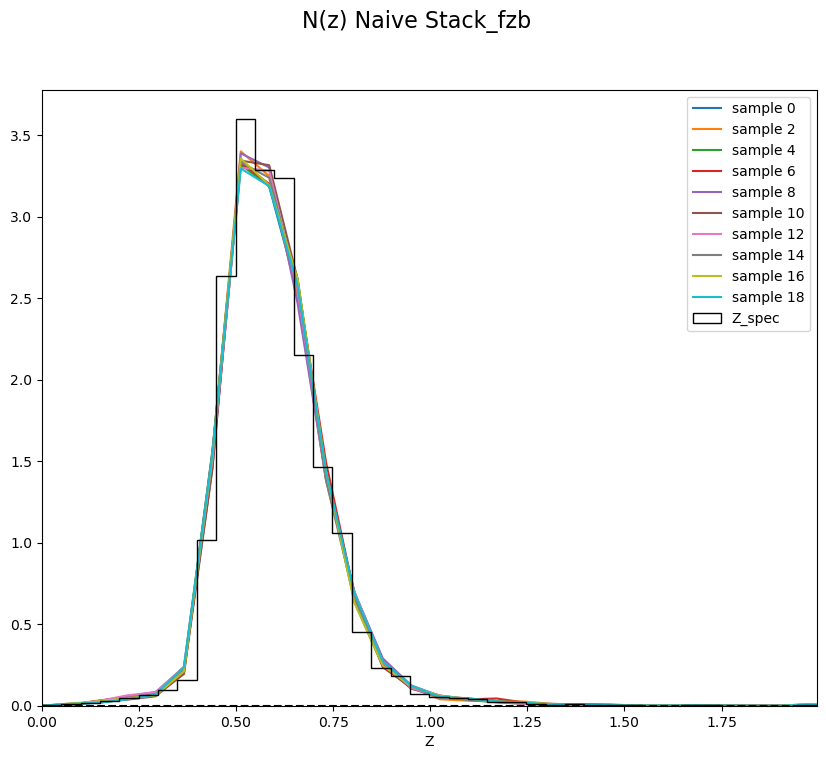

In [32]:
fig, axs = plt.subplots(figsize=(10,8))
for i in range(0, 20, 2):
    newens_fzb[i].plot_native(axes=axs, label=f"sample {i}")
axs.plot([0,3],[0,0],'k--')
axs.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,z_max,41),color='black',label='Z_spec')
axs.set_xlim(0,z_max)
axs.set_xlabel('Z')
axs.legend(loc='upper right')
plt.suptitle('N(z) Naive Stack_fzb',fontsize=16)

Text(0.5, 0.98, 'N(z) Naive Stack FzB')

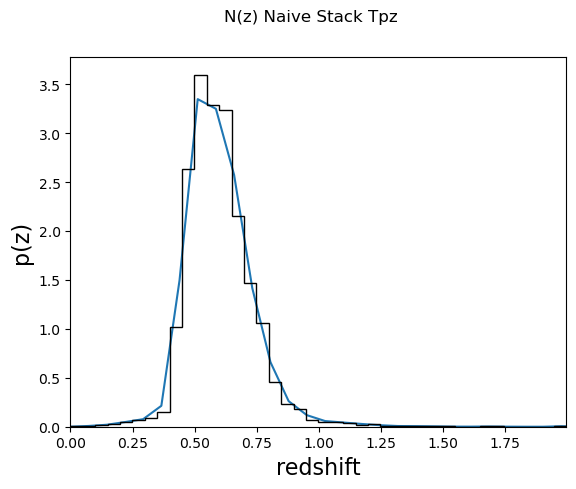

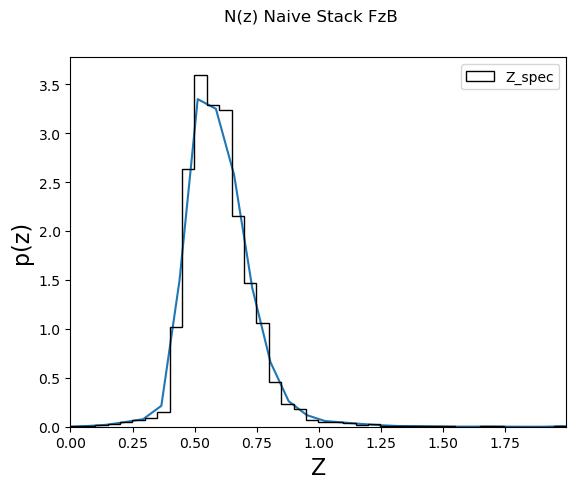

In [33]:
naive_nz_tpz = qp.read(f"NaiveStack_NZ_tpz.hdf5")
naive_nz_fzb = qp.read(f"NaiveStack_NZ_fzb.hdf5")
naive_nz_tpz.plot_native(xlim=(0,z_max))
plt.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,z_max,41),color='black',label='Z_spec')
plt.suptitle('N(z) Naive Stack Tpz')
naive_nz_fzb.plot_native(xlim=(0,z_max))
plt.hist(ztrue,density=True,histtype='step',bins=np.linspace(0,z_max,41),color='black',label='Z_spec')
plt.xlabel('Z')
plt.legend(loc='upper right')
plt.suptitle('N(z) Naive Stack FzB')

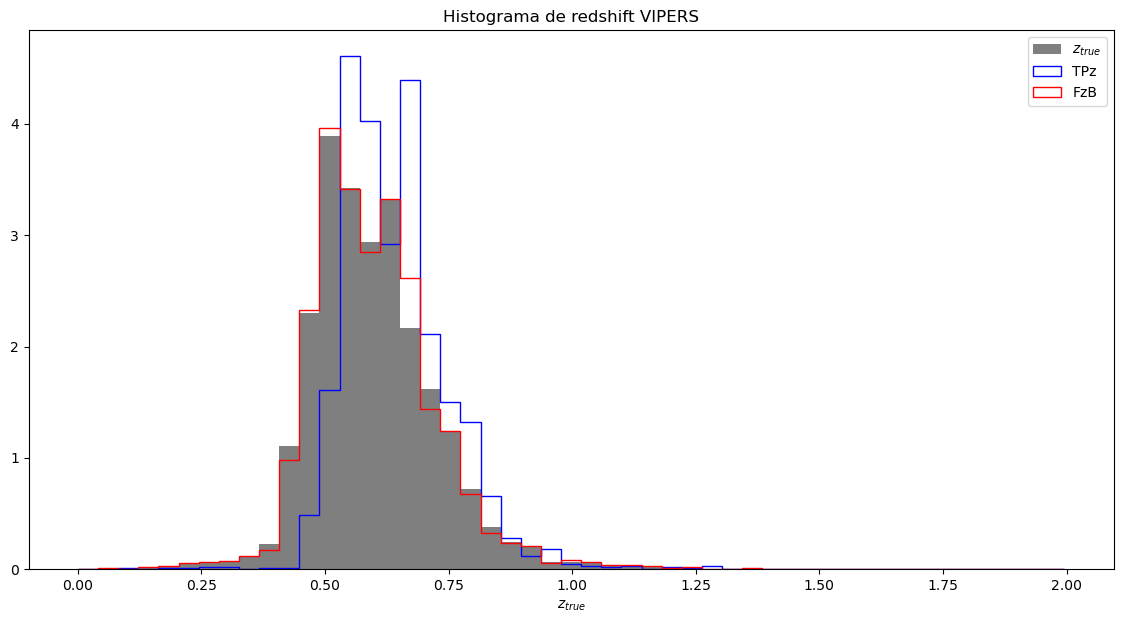

In [43]:
plt.figure(figsize=(14,7))
zgrid = np.linspace(0,max(ztrue),50)
y = plt.hist(ztrue,bins=zgrid,label=r'$z_{true}$',alpha=0.5 ,density=True,color='black')#,histtype='step')
t = plt.hist(zphot1,bins=zgrid,label='TPz', alpha=1, density=True,color='blue',histtype='step')
g = plt.hist(zphot2,bins=zgrid,label='FzB', alpha=1, density=True,color='red',histtype='step')
plt.xlabel(r'$z_{true}$')
#plt.xlim(0,1.4)
plt.title(f'Histograma de redshift {catalog}')
plt.legend()

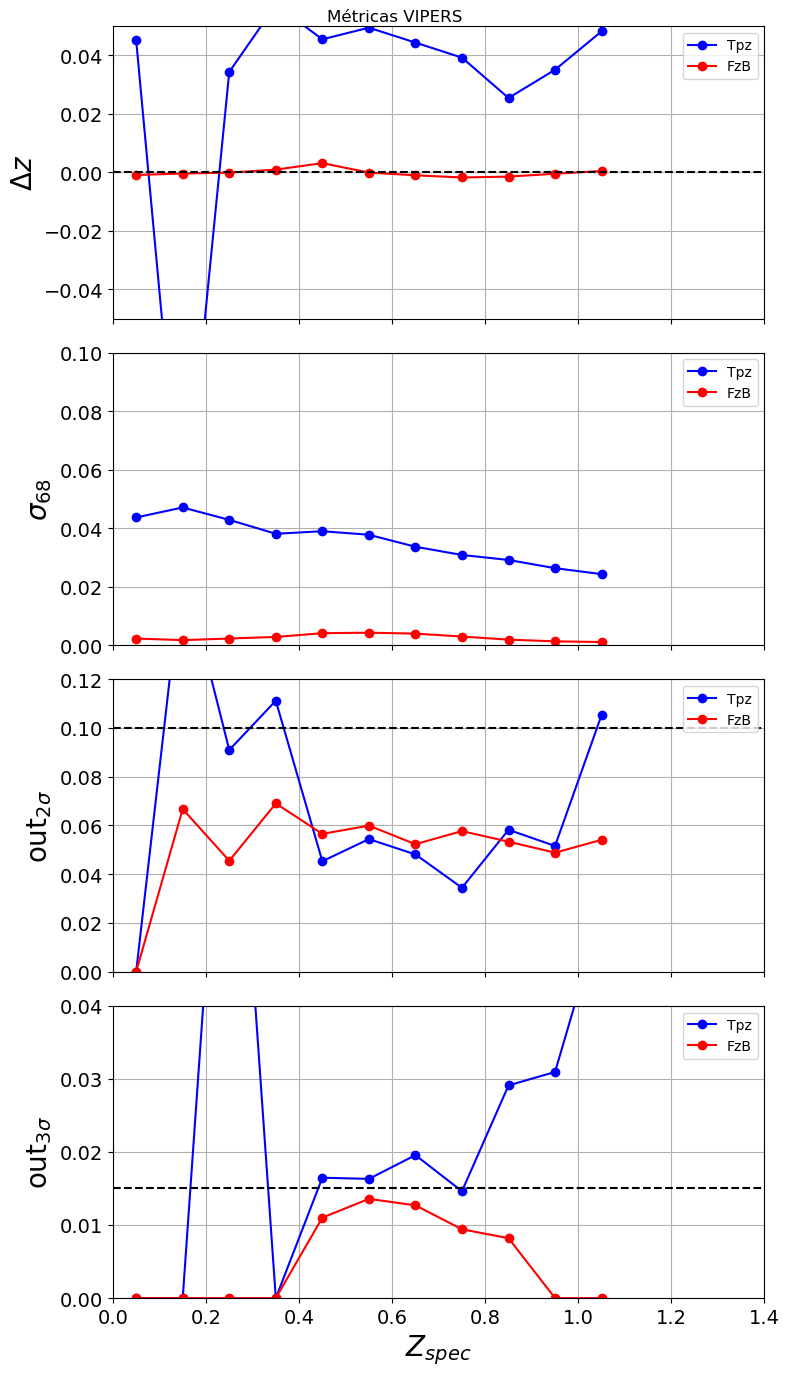

In [45]:

plot_metrics_comparation(ztrue,zphot1,zphot2,initial=0,maximum=1.2,name1='Tpz',name2='FzB',title=f'Métricas {catalog}')#,path_to_save=f'/home/iago.dias/control_metrics_{catalog}_cut.png')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_13310/1607036831.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/tmp/ipykernel_13310/1607036831.py:35: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ztrue, shade=True, label='z$_{true}$',bw_adjust=0.3)
/home/iago/miniforge3/envs/rail_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_13310/1607036831.py:36: FutureWarning: 



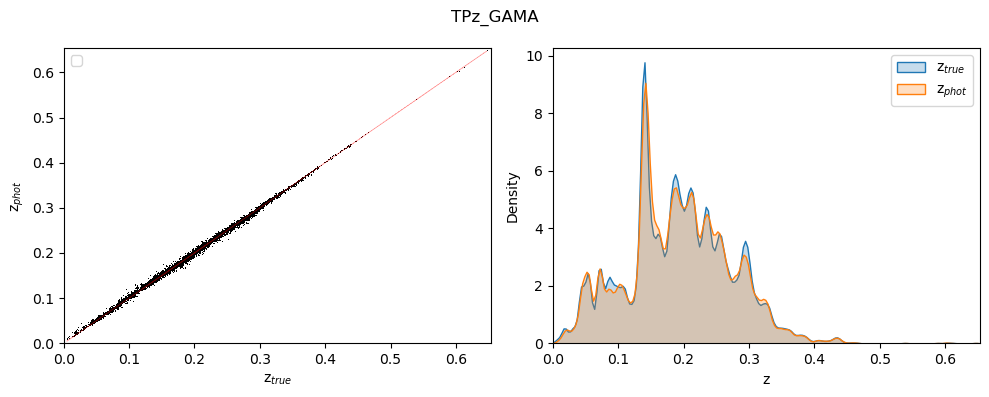

In [43]:
plot_old_valid(zphot2,ztrue,f'TPz_{catalog}')

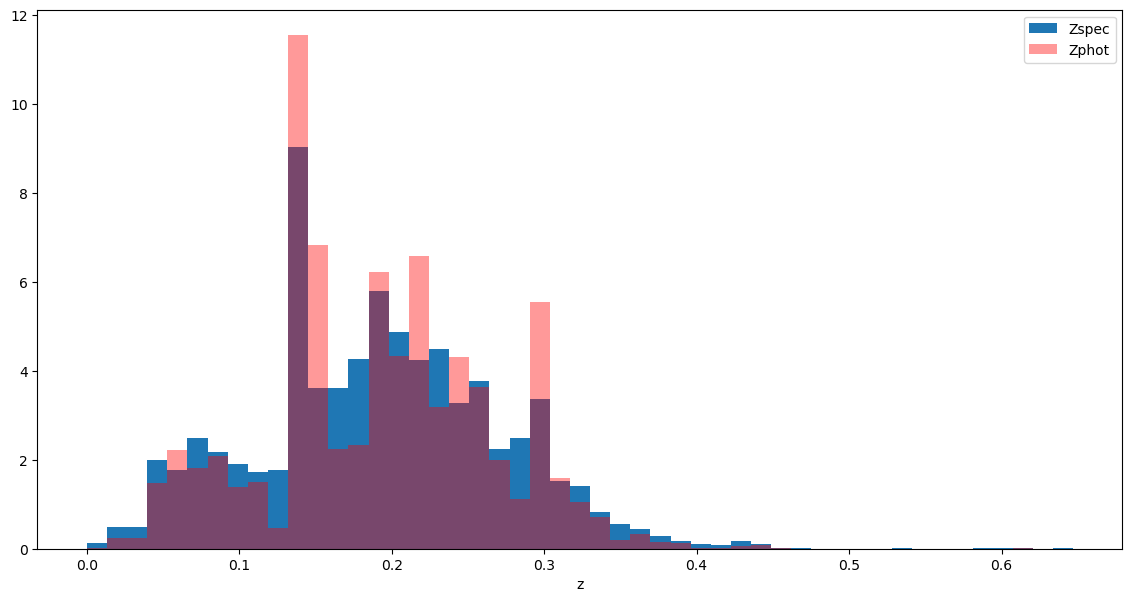

In [44]:
plt.figure(figsize=(14,7))
y = plt.hist(ztrue,bins=zgrid,label='Zspec', density=True)
t = plt.hist(zphot1,bins=zgrid,label='Zphot', alpha=0.4, density=True,color='red')
plt.xlabel('z')
#plt.xlim(0,1.4)
plt.legend()